In [1]:
using BenchmarkTools, DataFrames, ExcelFiles, XLSX, Plots, LinearRegression, Polynomials, Plots.PlotMeasures, LinearAlgebra

Este código está hecho con el fin de hacer el análisis de datos de cinética enzimática con inhibidores, un proceso más eficiente, rápido y confiable. Esto se logra al semiautomatizar el procesamiento de estos datos. 

Estos cálculos estpan basados en la ecuación de Michaelis Menten, la cual se muestra a continuación. 

$$V = \frac{V_{max}[S]}{K_m + [S]}$$ 

No obstante, utilizando el gráfico de Lineweaver-Burk y haciendo una regresión lineal de los valores inversos, podemos obtener los parámetros: $V_o$ y $K_m$ a través de la sieguiente expresión matemática.

$$y = mx + b \Longrightarrow \frac{1}{V} = \frac{K_m + [S]}{V_{max}[S]} + \frac{1}{V_{max}}$$

$$\Longrightarrow m = \frac{K_m}{V_{max}}$$

$$\Longrightarrow b = \frac{1}{V_{max}}$$

Este código está diseñado para procesar los datos de forma automática para no requerir la intervención del usuario y poder hacerlo rápido y con menor posibilidad de error.

In [2]:
function slicematrix(A::AbstractMatrix)
    return [A[:,i] for i in 1:size(A,2)]
end

slicematrix (generic function with 1 method)

In [3]:
A = convert(Matrix{Float64}, XLSX.readdata("enzyme_kinetics_inhibitora.xlsx", "Hoja1", "A3:F12"))

10×6 Matrix{Float64}:
 0.2   16.67   6.25   5.56  10.0    8.89
 0.25  20.0    7.69   6.67  11.11  10.81
 0.33  24.98  10.0    8.33  12.5   13.78
 0.5   33.33  14.29  11.11  14.29  19.05
 1.0   50.0   25.0   16.67  16.67  30.77
 2.0   66.67  40.0   22.22  18.18  44.44
 2.5   71.4   45.45  23.81  18.52  48.78
 3.33  76.92  52.63  25.64  18.87  54.06
 4.0   80.0   57.14  26.67  19.0   57.14
 5.0   83.33  62.5   27.77  19.23  60.6

In [4]:
slmtx = slicematrix(A) #cada dolumna de la matrz donde se encuentran los datos la partimos en vectores individuales

6-element Vector{Vector{Float64}}:
 [0.2, 0.25, 0.33, 0.5, 1.0, 2.0, 2.5, 3.33, 4.0, 5.0]
 [16.67, 20.0, 24.98, 33.33, 50.0, 66.67, 71.4, 76.92, 80.0, 83.33]
 [6.25, 7.69, 10.0, 14.29, 25.0, 40.0, 45.45, 52.63, 57.14, 62.5]
 [5.56, 6.67, 8.33, 11.11, 16.67, 22.22, 23.81, 25.64, 26.67, 27.77]
 [10.0, 11.11, 12.5, 14.29, 16.67, 18.18, 18.52, 18.87, 19.0, 19.23]
 [8.89, 10.81, 13.78, 19.05, 30.77, 44.44, 48.78, 54.06, 57.14, 60.6]

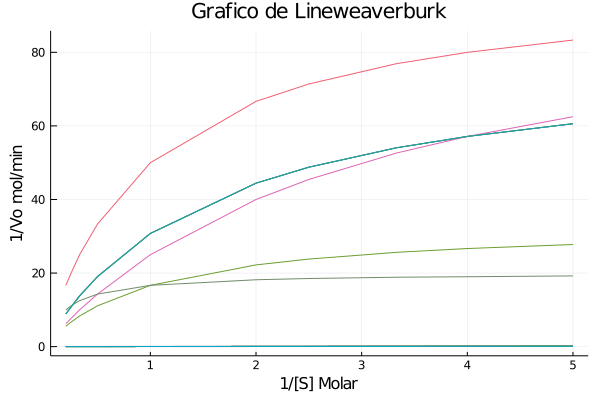

In [28]:
for i = length(slmtx)
    x = plot!(slmtx[1], slmtx[i], xlabel = "1/[S] Molar", ylabel= "1/Vo mol/min", title = "Grafico de Lineweaverburk")
    display(x)
end #graficamos cada uno de los ensayos para ver el comportamiento con los distintos inhibidores

In [10]:
inv_slmtx = []

for i = slmtx[1:length(slmtx)]
    push!(inv_slmtx, round.(1 ./ i, digits=4))
end
return inv_slmtx

6-element Vector{Any}:
 [5.0, 4.0, 3.0303, 2.0, 1.0, 0.5, 0.4, 0.3003, 0.25, 0.2]
 [0.06, 0.05, 0.04, 0.03, 0.02, 0.015, 0.014, 0.013, 0.0125, 0.012]
 [0.16, 0.13, 0.1, 0.07, 0.04, 0.025, 0.022, 0.019, 0.0175, 0.016]
 [0.1799, 0.1499, 0.12, 0.09, 0.06, 0.045, 0.042, 0.039, 0.0375, 0.036]
 [0.1, 0.09, 0.08, 0.07, 0.06, 0.055, 0.054, 0.053, 0.0526, 0.052]
 [0.1125, 0.0925, 0.0726, 0.0525, 0.0325, 0.0225, 0.0205, 0.0185, 0.0175, 0.0165]

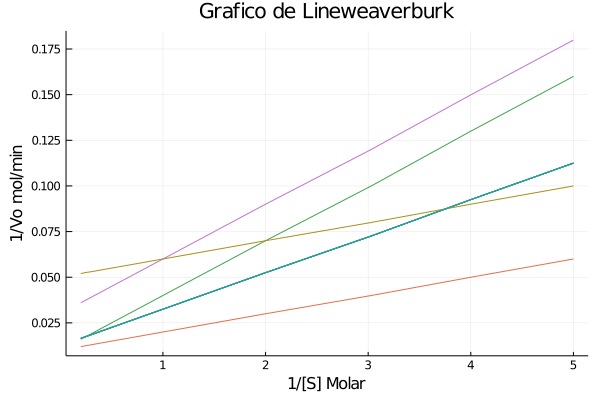

In [24]:
for i = length(inv_slmtx)
    p = plot!(inv_slmtx[1], inv_slmtx[i], xlabel = "1/[S] Molar", ylabel= "1/Vo mol/min", title = "Grafico de Lineweaverburk")
    display(p)
end  

In [30]:
slopes = []
Vmax = []

for i = 2:length(inv_slmtx)
    std_curv = linregress(inv_slmtx[1], inv_slmtx[i])
    push!(slopes, round.(LinearRegression.slope(std_curv), digits=2))
    push!(Vmax, round.(1 ./ LinearRegression.bias(std_curv), digits=1))
end
return slopes, Vmax #obtenemos la pendiente y la ordenada al origen a partir de una regresióń lineal de cada ensayo

(Any[[0.01], [0.03], [0.03], [0.01], [0.02]], Any[100.1, 100.2, 33.3, 20.0, 80.1])

In [31]:
for i = 2:length(slopes)
    if slopes[1] == slopes[i-1]
        println("El ensayo ", [i], " Es un inhibidor acompetitivo")
    end
end #evaluamos que arreglos de datos tienen la misma pendiente, lo que nos indica el tipo de inhibidor que evaluamos

El ensayo [2] Es un inhibidor acompetitivo
El ensayo [5] Es un inhibidor acompetitivo


In [32]:
for i = 3:length(Vmax)
    if Vmax[1] == Vmax[i]
        println("El ensayo ", [i], " Es un inhibidor competitivo")
    end
end

In [33]:
for i = 1:length(Vmax)
    println("Vmax de ensayo ", i, " = ", Vmax[i],"mol/min")
end

Vmax de ensayo 1 = 100.1mol/min
Vmax de ensayo 2 = 100.2mol/min
Vmax de ensayo 3 = 33.3mol/min
Vmax de ensayo 4 = 20.0mol/min
Vmax de ensayo 5 = 80.1mol/min


In [46]:
for i =1:length(slopes)
    println("Km de ensayo ", i, " = ", round.(slopes[i] * Vmax[i], digits=2), "molar ")
end

Km de ensayo 1 = [1.42]molar 
Km de ensayo 2 = [2.95]molar 
Km de ensayo 3 = [0.94]molar 
Km de ensayo 4 = [0.2]molar 
Km de ensayo 5 = [1.52]molar 
